# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import mlflow
from collections import defaultdict
from scipy.stats import zscore

# original library

import common as com
import pytorch_modeler as modeler
from pytorch_model import LSTM_AutoEncoder as Model
from pytorch_utils import filtered_load_model
import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
#with open("./config.yaml", 'rb') as f:
#    config = yaml.load(f)

log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_path = INPUT_ROOT + "/dev_data"
add_dev_path = INPUT_ROOT + "/add_dev_data"
# machine type
MACHINE_TYPE = config['IO_OPTION']['MACHINE_TYPE']
machine_types = os.listdir(dev_path)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
PKL_DIR = OUTPUT_ROOT + '/pkl'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(PKL_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/working/research/dcase2020/result/2D/LSTM_AEs/bidirectional_LSTM_AE/config.yaml'

## make path list and train/valid split

In [7]:
############################################################################
# make path set and train/valid split
############################################################################
'''
train_paths[machine_type]['train' or 'valid'] = path
'''
dev_train_paths = {}
add_train_paths = {}
train_paths = {}

In [8]:
for machine_type in machine_types:
    # dev train
    dev_train_paths = ["{}/{}/train/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(dev_path, machine_type))]
    dev_train_paths = sorted(dev_train_paths)
    # add_dev train
    add_train_paths = ["{}/{}/train/".format(add_dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(add_dev_path, machine_type))]
    add_train_paths = sorted(add_train_paths)
    # valid
    dev_valid_paths = ["{}/{}/test/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/test".format(dev_path, machine_type))]
    dev_valid_paths = sorted(dev_valid_paths)
    
    train_paths[machine_type] = {}
    train_paths[machine_type]['train'] = dev_train_paths + add_train_paths
    train_paths[machine_type]['valid'] = dev_valid_paths

## training

In [9]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(train_paths, machine_type)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)         # debug
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    logger.info('TRAINING')
    # parameter setting
    net = Model(sample_rate=config['preprocessing']['sample_rate'],
                window_size=config['preprocessing']['window_size'],
                hop_size=config['preprocessing']['hop_size'],
                mel_bins=config['preprocessing']['mel_bins'],
                fmin=config['preprocessing']['fmin'],
                fmax=config['preprocessing']['fmax'])
    #pretrained_dict = torch.load(config['IO_OPTION']['PREMODEL_PATH'])
    #net = filtered_load_model(net, pretrained_dict)
    optimizer = optim.Adam(net.parameters(), lr=1e-2)
    criterion = nn.MSELoss()
    num_epochs = config['fit']['num_epochs']
    history = modeler.train_net(net, dataloaders_dict, criterion, optimizer, num_epochs, writer)
    # output
    model = history['model']
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    torch.save(model.state_dict(), model_out_path)
    logger.info('\n success:{0} \n'.format(machine_type) + \
                    'model_out_path ==> \n {0}'.format(model_out_path))
    #  close writer for tensorbord
    writer.close()
    #modeler.mlflow_log(history, config, machine_type, model_out_path, tb_log_dir)
    com.toc()
    return history

In [10]:
machine_types

['fan', 'pump', 'slider', 'ToyCar', 'ToyConveyor', 'valve']

2020-11-07 20:00:44,623 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2020-11-07 20:00:44,624 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-07 20:00:45,459 - 00_train.py - INFO - TRAINING


use: cuda:0


100%|██████████| 1803/1803 [00:14<00:00, 120.24it/s]


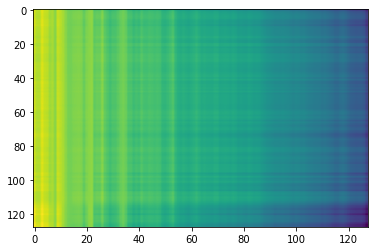

2020-11-07 20:01:18,739 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:68.714311, valid_AUC:0.499745, valid_pAUC:0.512267
100%|██████████| 1803/1803 [00:15<00:00, 113.61it/s]
2020-11-07 20:01:51,399 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:16.822995, valid_AUC:0.517553, valid_pAUC:0.514612
100%|██████████| 1803/1803 [00:15<00:00, 118.95it/s]
2020-11-07 20:02:23,202 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:16.670128, valid_AUC:0.503309, valid_pAUC:0.512698
100%|██████████| 1803/1803 [00:15<00:00, 119.27it/s]
2020-11-07 20:02:55,213 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:16.662701, valid_AUC:0.507808, valid_pAUC:0.513214
100%|██████████| 1803/1803 [00:15<00:00, 119.44it/s]
2020-11-07 20:03:26,984 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:16.426266, valid_AUC:0.498127, valid_pAUC:0.511142
100%|██████████| 1803/1803 [00:15<00:00, 119.12it/s]
2020-11-07 20:03:58,830 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:15.839466, valid_A

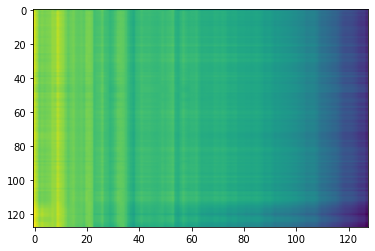

2020-11-07 20:06:06,606 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:14.150114, valid_AUC:0.521613, valid_pAUC:0.516215
100%|██████████| 1803/1803 [00:15<00:00, 119.67it/s]
2020-11-07 20:06:38,361 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:13.929331, valid_AUC:0.532454, valid_pAUC:0.513158
100%|██████████| 1803/1803 [00:15<00:00, 119.51it/s]
2020-11-07 20:07:10,096 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:13.644606, valid_AUC:0.541531, valid_pAUC:0.513017
100%|██████████| 1803/1803 [00:14<00:00, 120.50it/s]
2020-11-07 20:07:41,805 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:13.588111, valid_AUC:0.516456, valid_pAUC:0.508609
100%|██████████| 1803/1803 [00:14<00:00, 122.40it/s]
2020-11-07 20:08:12,891 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:13.460356, valid_AUC:0.524505, valid_pAUC:0.505224
100%|██████████| 1803/1803 [00:14<00:00, 121.32it/s]
2020-11-07 20:08:44,110 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:13.321693, v

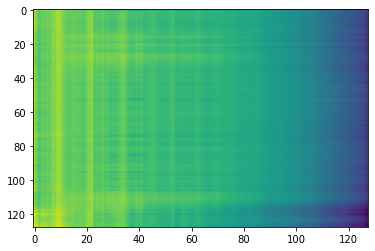

2020-11-07 20:11:20,327 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:12.889534, valid_AUC:0.527158, valid_pAUC:0.503930
100%|██████████| 1803/1803 [00:14<00:00, 122.89it/s]
2020-11-07 20:11:51,346 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:12.866822, valid_AUC:0.536156, valid_pAUC:0.503948
100%|██████████| 1803/1803 [00:14<00:00, 122.45it/s]
2020-11-07 20:12:22,486 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:12.759889, valid_AUC:0.547083, valid_pAUC:0.508412
100%|██████████| 1803/1803 [00:14<00:00, 122.36it/s]
2020-11-07 20:12:53,764 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:12.687602, valid_AUC:0.553199, valid_pAUC:0.506049
100%|██████████| 1803/1803 [00:14<00:00, 122.15it/s]
2020-11-07 20:13:25,081 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:12.745052, valid_AUC:0.552823, valid_pAUC:0.507165
100%|██████████| 1803/1803 [00:14<00:00, 122.64it/s]
2020-11-07 20:13:56,228 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:12.570296, v

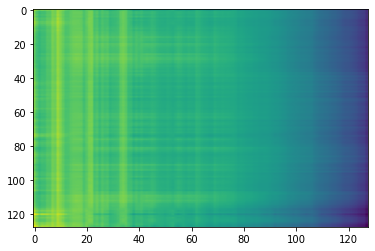

2020-11-07 20:16:32,241 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:12.238449, valid_AUC:0.562951, valid_pAUC:0.509791
100%|██████████| 1803/1803 [00:14<00:00, 121.95it/s]
2020-11-07 20:17:03,391 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:12.126574, valid_AUC:0.558674, valid_pAUC:0.506677
100%|██████████| 1803/1803 [00:14<00:00, 122.54it/s]
2020-11-07 20:17:34,394 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:12.180487, valid_AUC:0.558530, valid_pAUC:0.508797
100%|██████████| 1803/1803 [00:14<00:00, 121.96it/s]
2020-11-07 20:18:05,525 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:11.885299, valid_AUC:0.554736, valid_pAUC:0.507981
100%|██████████| 1803/1803 [00:14<00:00, 121.14it/s]
2020-11-07 20:18:36,811 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:11.774857, valid_AUC:0.543505, valid_pAUC:0.507099
100%|██████████| 1803/1803 [00:14<00:00, 121.66it/s]
2020-11-07 20:19:08,077 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:11.675598, v

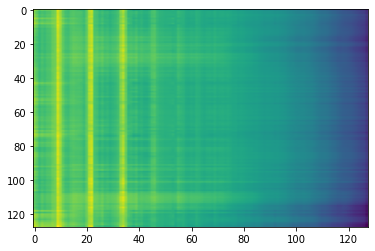

2020-11-07 20:21:43,874 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:11.507571, valid_AUC:0.544172, valid_pAUC:0.507859
100%|██████████| 1803/1803 [00:14<00:00, 122.09it/s]
2020-11-07 20:22:14,939 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:11.492893, valid_AUC:0.550214, valid_pAUC:0.507006
100%|██████████| 1803/1803 [00:14<00:00, 122.16it/s]
2020-11-07 20:22:46,159 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:11.372499, valid_AUC:0.543574, valid_pAUC:0.508178
100%|██████████| 1803/1803 [00:14<00:00, 122.39it/s]
2020-11-07 20:23:17,353 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:11.275919, valid_AUC:0.538045, valid_pAUC:0.507418
100%|██████████| 1803/1803 [00:14<00:00, 122.25it/s]
2020-11-07 20:23:48,465 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:11.205094, valid_AUC:0.544330, valid_pAUC:0.510288
100%|██████████| 1803/1803 [00:14<00:00, 122.01it/s]
2020-11-07 20:24:19,615 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:11.281287, v

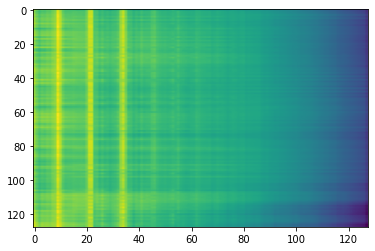

2020-11-07 20:26:55,485 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:10.788924, valid_AUC:0.555763, valid_pAUC:0.508497
100%|██████████| 1803/1803 [00:14<00:00, 122.25it/s]
2020-11-07 20:27:26,730 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:10.733685, valid_AUC:0.561465, valid_pAUC:0.508581
100%|██████████| 1803/1803 [00:14<00:00, 122.15it/s]
2020-11-07 20:27:57,867 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:10.662624, valid_AUC:0.551459, valid_pAUC:0.510138
100%|██████████| 1803/1803 [00:14<00:00, 122.15it/s]
2020-11-07 20:28:29,051 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:10.711755, valid_AUC:0.562046, valid_pAUC:0.511639
100%|██████████| 1803/1803 [00:14<00:00, 122.74it/s]
2020-11-07 20:29:00,274 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:10.812479, valid_AUC:0.562491, valid_pAUC:0.509904
100%|██████████| 1803/1803 [00:14<00:00, 122.05it/s]
2020-11-07 20:29:31,363 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:10.904782, v

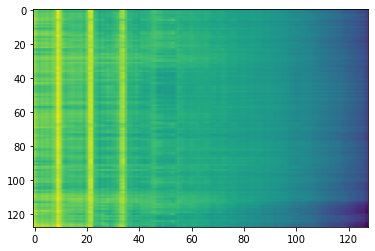

2020-11-07 20:32:09,463 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:10.395908, valid_AUC:0.560535, valid_pAUC:0.512745
100%|██████████| 1803/1803 [00:15<00:00, 118.69it/s]
2020-11-07 20:32:41,184 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:10.412819, valid_AUC:0.555479, valid_pAUC:0.512558
100%|██████████| 1803/1803 [00:14<00:00, 120.58it/s]
2020-11-07 20:33:12,666 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:10.315490, valid_AUC:0.567160, valid_pAUC:0.514218
100%|██████████| 1803/1803 [00:15<00:00, 120.06it/s]
2020-11-07 20:33:44,219 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:10.197640, valid_AUC:0.564467, valid_pAUC:0.512811
100%|██████████| 1803/1803 [00:15<00:00, 119.07it/s]
2020-11-07 20:34:16,038 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:10.241274, valid_AUC:0.561067, valid_pAUC:0.513130
100%|██████████| 1803/1803 [00:15<00:00, 119.85it/s]
2020-11-07 20:34:47,525 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:10.145441, v

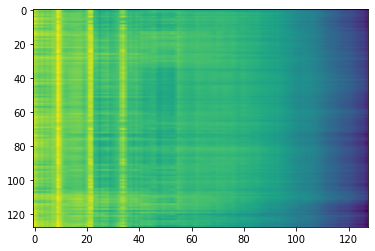

2020-11-07 20:37:29,240 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:9.973285, valid_AUC:0.563640, valid_pAUC:0.511320
100%|██████████| 1803/1803 [00:15<00:00, 118.81it/s]
2020-11-07 20:38:01,151 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:10.021560, valid_AUC:0.567427, valid_pAUC:0.514808
100%|██████████| 1803/1803 [00:15<00:00, 117.42it/s]
2020-11-07 20:38:33,320 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:9.893778, valid_AUC:0.560809, valid_pAUC:0.513936
100%|██████████| 1803/1803 [00:15<00:00, 115.05it/s]
2020-11-07 20:39:05,899 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:9.862447, valid_AUC:0.570538, valid_pAUC:0.515718
100%|██████████| 1803/1803 [00:15<00:00, 116.63it/s]
2020-11-07 20:39:38,585 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:9.781887, valid_AUC:0.570221, valid_pAUC:0.514687
100%|██████████| 1803/1803 [00:15<00:00, 116.45it/s]
2020-11-07 20:40:11,047 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:9.764616, valid_

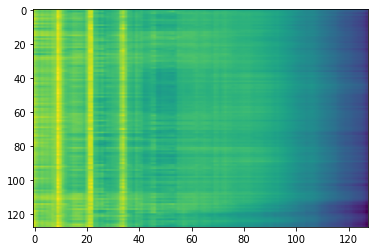

2020-11-07 20:42:58,333 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:9.607286, valid_AUC:0.582610, valid_pAUC:0.514583
100%|██████████| 1803/1803 [00:16<00:00, 112.41it/s]
2020-11-07 20:43:31,757 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:9.592135, valid_AUC:0.578047, valid_pAUC:0.512895
100%|██████████| 1803/1803 [00:15<00:00, 114.15it/s]
2020-11-07 20:44:04,663 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:9.557350, valid_AUC:0.589097, valid_pAUC:0.515202
100%|██████████| 1803/1803 [00:15<00:00, 114.47it/s]
2020-11-07 20:44:37,452 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:9.581340, valid_AUC:0.581610, valid_pAUC:0.514255
100%|██████████| 1803/1803 [00:16<00:00, 111.30it/s]
2020-11-07 20:45:10,783 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:9.497050, valid_AUC:0.577349, valid_pAUC:0.513946
100%|██████████| 1803/1803 [00:15<00:00, 113.30it/s]
2020-11-07 20:45:43,957 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:9.492453, valid_A

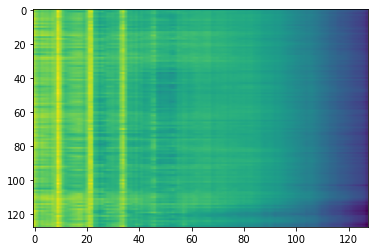

2020-11-07 20:48:31,176 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:9.327255, valid_AUC:0.591752, valid_pAUC:0.514902
100%|██████████| 1803/1803 [00:16<00:00, 111.74it/s]
2020-11-07 20:49:04,638 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:9.299073, valid_AUC:0.582752, valid_pAUC:0.513617
100%|██████████| 1803/1803 [00:15<00:00, 114.97it/s]
2020-11-07 20:49:37,179 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:9.364286, valid_AUC:0.580064, valid_pAUC:0.512998
100%|██████████| 1803/1803 [00:16<00:00, 112.12it/s]
2020-11-07 20:50:10,213 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:9.239676, valid_AUC:0.597301, valid_pAUC:0.514977
100%|██████████| 1803/1803 [00:16<00:00, 111.67it/s]
2020-11-07 20:50:43,518 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:9.267313, valid_AUC:0.585467, valid_pAUC:0.514096
100%|██████████| 1803/1803 [00:15<00:00, 116.41it/s]
2020-11-07 20:51:15,796 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:9.257620, valid_A

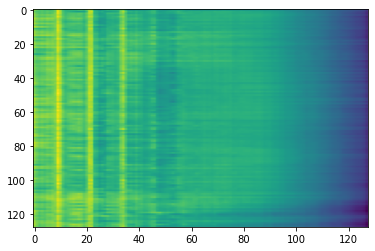

2020-11-07 20:53:57,525 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:9.093640, valid_AUC:0.589444, valid_pAUC:0.513420
2020-11-07 20:53:57,572 - 00_train.py - INFO - 
 success:fan 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AEs/bidirectional_LSTM_AE/models/fan_model.pth


elapsed time: 3192.950008392 [sec]


2020-11-07 20:53:58,132 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2020-11-07 20:53:58,133 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-07 20:53:58,134 - 00_train.py - INFO - TRAINING
  0%|          | 0/181 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 832/832 [00:12<00:00, 68.29it/s]


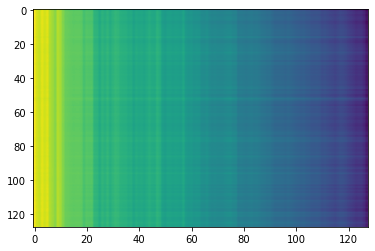

2020-11-07 20:55:17,990 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:74.397565, valid_AUC:0.570527, valid_pAUC:0.495157
100%|██████████| 832/832 [00:07<00:00, 117.13it/s]
2020-11-07 20:55:40,489 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:17.949182, valid_AUC:0.684161, valid_pAUC:0.578399
100%|██████████| 832/832 [00:07<00:00, 113.92it/s]
2020-11-07 20:56:02,674 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:17.892201, valid_AUC:0.625388, valid_pAUC:0.523453
100%|██████████| 832/832 [00:07<00:00, 117.71it/s]
2020-11-07 20:56:24,928 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:17.754903, valid_AUC:0.685747, valid_pAUC:0.564053
100%|██████████| 832/832 [00:07<00:00, 115.52it/s]
2020-11-07 20:56:47,614 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:17.678283, valid_AUC:0.672127, valid_pAUC:0.559728
100%|██████████| 832/832 [00:07<00:00, 117.07it/s]
2020-11-07 20:57:09,983 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:17.645226, valid_AUC:0.69261

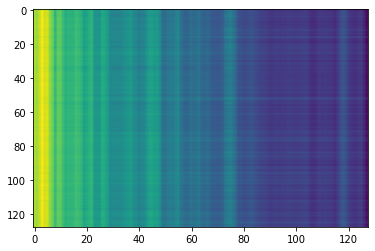

2020-11-07 20:58:38,953 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:16.167144, valid_AUC:0.653553, valid_pAUC:0.564541
100%|██████████| 832/832 [00:07<00:00, 117.00it/s]
2020-11-07 20:59:01,000 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:15.617647, valid_AUC:0.660266, valid_pAUC:0.579739
100%|██████████| 832/832 [00:07<00:00, 110.12it/s]
2020-11-07 20:59:23,808 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:15.475798, valid_AUC:0.659282, valid_pAUC:0.565972
100%|██████████| 832/832 [00:07<00:00, 112.05it/s]
2020-11-07 20:59:46,089 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:15.398593, valid_AUC:0.676887, valid_pAUC:0.583394
100%|██████████| 832/832 [00:07<00:00, 115.48it/s]
2020-11-07 21:00:08,945 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:15.290818, valid_AUC:0.684225, valid_pAUC:0.593171
100%|██████████| 832/832 [00:07<00:00, 107.25it/s]
2020-11-07 21:00:31,796 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:15.347535, valid_AUC:0

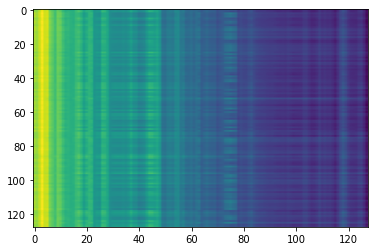

2020-11-07 21:02:24,220 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:15.004073, valid_AUC:0.676632, valid_pAUC:0.585587
100%|██████████| 832/832 [00:07<00:00, 111.58it/s]
2020-11-07 21:02:47,217 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:14.947819, valid_AUC:0.665069, valid_pAUC:0.571424
100%|██████████| 832/832 [00:07<00:00, 117.66it/s]
2020-11-07 21:03:09,658 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:14.871771, valid_AUC:0.676591, valid_pAUC:0.584430
100%|██████████| 832/832 [00:07<00:00, 117.62it/s]
2020-11-07 21:03:31,629 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:14.858129, valid_AUC:0.659520, valid_pAUC:0.546449
100%|██████████| 832/832 [00:07<00:00, 117.13it/s]
2020-11-07 21:03:53,561 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:14.806794, valid_AUC:0.639670, valid_pAUC:0.539931
100%|██████████| 832/832 [00:07<00:00, 117.26it/s]
2020-11-07 21:04:15,572 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:14.634207, valid_AUC:0

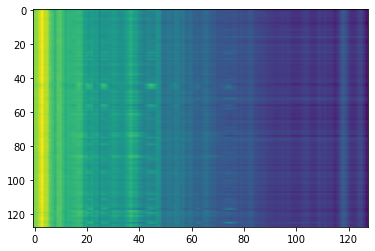

2020-11-07 21:06:07,231 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:13.569827, valid_AUC:0.676580, valid_pAUC:0.558693
100%|██████████| 832/832 [00:07<00:00, 117.53it/s]
2020-11-07 21:06:29,447 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:13.540702, valid_AUC:0.653918, valid_pAUC:0.536458
100%|██████████| 832/832 [00:07<00:00, 113.21it/s]
2020-11-07 21:06:52,304 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:13.414412, valid_AUC:0.699063, valid_pAUC:0.590156
100%|██████████| 832/832 [00:07<00:00, 117.20it/s]
2020-11-07 21:07:14,293 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:13.373868, valid_AUC:0.669216, valid_pAUC:0.551017
100%|██████████| 832/832 [00:07<00:00, 117.79it/s]
2020-11-07 21:07:36,209 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:13.240628, valid_AUC:0.659589, valid_pAUC:0.546540
100%|██████████| 832/832 [00:07<00:00, 117.89it/s]
2020-11-07 21:07:58,042 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:13.230317, valid_AUC:0

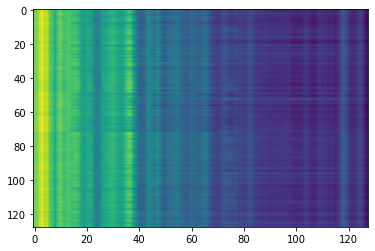

2020-11-07 21:09:48,879 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:12.608645, valid_AUC:0.686036, valid_pAUC:0.573556
100%|██████████| 832/832 [00:07<00:00, 110.84it/s]
2020-11-07 21:10:11,933 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:12.495534, valid_AUC:0.667575, valid_pAUC:0.546174
100%|██████████| 832/832 [00:07<00:00, 109.48it/s]
2020-11-07 21:10:34,712 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:12.533047, valid_AUC:0.673490, valid_pAUC:0.553880
100%|██████████| 832/832 [00:07<00:00, 106.34it/s]
2020-11-07 21:10:57,728 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:12.365538, valid_AUC:0.658976, valid_pAUC:0.541271
100%|██████████| 832/832 [00:08<00:00, 101.11it/s]
2020-11-07 21:11:22,036 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:12.200349, valid_AUC:0.684514, valid_pAUC:0.562713
100%|██████████| 832/832 [00:06<00:00, 121.11it/s]
2020-11-07 21:11:44,058 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:12.167807, valid_AUC:0

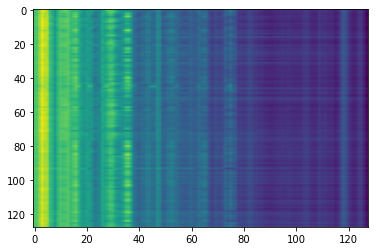

2020-11-07 21:13:35,126 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:11.900187, valid_AUC:0.674057, valid_pAUC:0.545474
100%|██████████| 832/832 [00:07<00:00, 115.97it/s]
2020-11-07 21:13:57,357 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:11.792691, valid_AUC:0.683432, valid_pAUC:0.555769
100%|██████████| 832/832 [00:07<00:00, 115.15it/s]
2020-11-07 21:14:19,824 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:11.901945, valid_AUC:0.686562, valid_pAUC:0.561799
100%|██████████| 832/832 [00:07<00:00, 113.44it/s]
2020-11-07 21:14:41,892 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:11.805851, valid_AUC:0.672078, valid_pAUC:0.542215
100%|██████████| 832/832 [00:07<00:00, 110.44it/s]
2020-11-07 21:15:04,325 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:11.734316, valid_AUC:0.683420, valid_pAUC:0.557870
100%|██████████| 832/832 [00:07<00:00, 115.71it/s]
2020-11-07 21:15:26,436 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:11.745856, valid_AUC:0

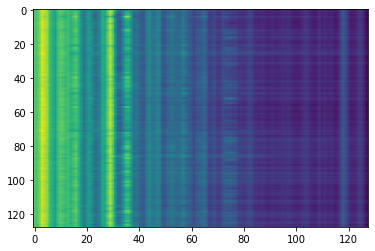

2020-11-07 21:17:18,365 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:11.478029, valid_AUC:0.684566, valid_pAUC:0.553271
100%|██████████| 832/832 [00:07<00:00, 118.21it/s]
2020-11-07 21:17:40,023 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:11.407710, valid_AUC:0.683183, valid_pAUC:0.549068
100%|██████████| 832/832 [00:07<00:00, 113.79it/s]
2020-11-07 21:18:02,257 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:11.513500, valid_AUC:0.680718, valid_pAUC:0.558144
100%|██████████| 832/832 [00:06<00:00, 118.87it/s]
2020-11-07 21:18:24,132 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:11.413375, valid_AUC:0.689618, valid_pAUC:0.563596
100%|██████████| 832/832 [00:06<00:00, 121.60it/s]
2020-11-07 21:18:45,736 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:11.449596, valid_AUC:0.680527, valid_pAUC:0.551017
100%|██████████| 832/832 [00:07<00:00, 112.64it/s]
2020-11-07 21:19:08,216 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:11.311670, valid_AUC:0

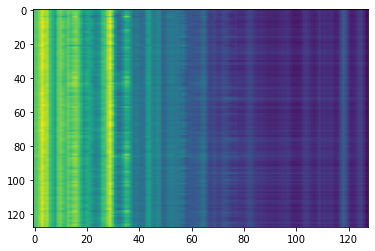

2020-11-07 21:20:59,506 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:11.187424, valid_AUC:0.698142, valid_pAUC:0.565729
100%|██████████| 832/832 [00:06<00:00, 122.09it/s]
2020-11-07 21:21:21,329 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:11.230792, valid_AUC:0.695972, valid_pAUC:0.561921
100%|██████████| 832/832 [00:07<00:00, 115.94it/s]
2020-11-07 21:21:43,518 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:11.163035, valid_AUC:0.695052, valid_pAUC:0.557901
100%|██████████| 832/832 [00:06<00:00, 121.61it/s]
2020-11-07 21:22:05,008 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:11.145382, valid_AUC:0.689352, valid_pAUC:0.559363
100%|██████████| 832/832 [00:06<00:00, 118.89it/s]
2020-11-07 21:22:26,632 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:11.106331, valid_AUC:0.688449, valid_pAUC:0.560581
100%|██████████| 832/832 [00:06<00:00, 121.27it/s]
2020-11-07 21:22:48,705 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:11.051739, valid_AUC:0

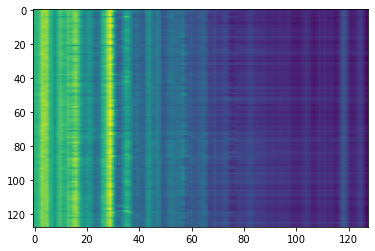

2020-11-07 21:24:40,460 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:10.778503, valid_AUC:0.681429, valid_pAUC:0.562165
100%|██████████| 832/832 [00:07<00:00, 108.14it/s]
2020-11-07 21:25:03,571 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:10.807643, valid_AUC:0.687541, valid_pAUC:0.557261
100%|██████████| 832/832 [00:07<00:00, 112.17it/s]
2020-11-07 21:25:26,135 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:10.866215, valid_AUC:0.689057, valid_pAUC:0.564297
100%|██████████| 832/832 [00:07<00:00, 116.70it/s]
2020-11-07 21:25:48,255 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:10.811043, valid_AUC:0.691794, valid_pAUC:0.565363
100%|██████████| 832/832 [00:07<00:00, 112.46it/s]
2020-11-07 21:26:10,515 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:10.846847, valid_AUC:0.693767, valid_pAUC:0.567982
100%|██████████| 832/832 [00:07<00:00, 112.02it/s]
2020-11-07 21:26:33,072 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:10.806090, valid_AUC:0

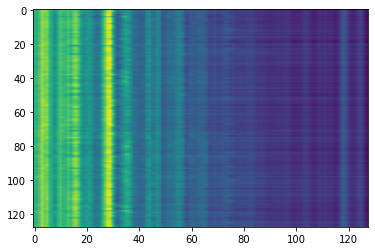

2020-11-07 21:28:25,041 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:10.686137, valid_AUC:0.691510, valid_pAUC:0.561373
100%|██████████| 832/832 [00:07<00:00, 110.98it/s]
2020-11-07 21:28:47,804 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:10.688122, valid_AUC:0.672419, valid_pAUC:0.557749
100%|██████████| 832/832 [00:07<00:00, 113.94it/s]
2020-11-07 21:29:10,452 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:10.731372, valid_AUC:0.674913, valid_pAUC:0.557657
100%|██████████| 832/832 [00:07<00:00, 117.15it/s]
2020-11-07 21:29:32,535 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:10.750067, valid_AUC:0.684659, valid_pAUC:0.561495
100%|██████████| 832/832 [00:07<00:00, 111.82it/s]
2020-11-07 21:29:54,976 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:10.598439, valid_AUC:0.703394, valid_pAUC:0.564632
100%|██████████| 832/832 [00:07<00:00, 110.49it/s]
2020-11-07 21:30:17,582 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:10.691580, valid_AUC:0

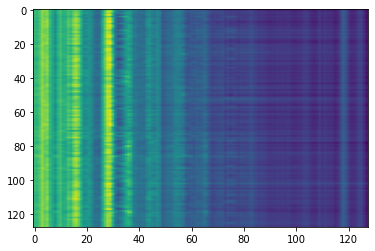

2020-11-07 21:32:08,703 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:10.608191, valid_AUC:0.684815, valid_pAUC:0.560094
2020-11-07 21:32:08,753 - 00_train.py - INFO - 
 success:pump 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AEs/bidirectional_LSTM_AE/models/pump_model.pth


elapsed time: 2290.622293472 [sec]


2020-11-07 21:32:09,293 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2020-11-07 21:32:09,293 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-07 21:32:09,295 - 00_train.py - INFO - TRAINING
  0%|          | 0/162 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 1246/1246 [00:18<00:00, 66.01it/s]


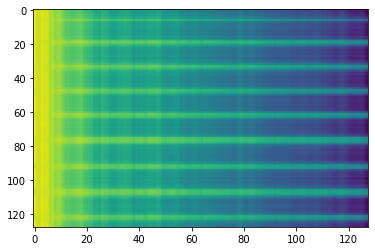

2020-11-07 21:33:33,657 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:91.319085, valid_AUC:0.480488, valid_pAUC:0.490357
100%|██████████| 1246/1246 [00:11<00:00, 107.04it/s]
2020-11-07 21:33:59,379 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:19.822755, valid_AUC:0.530597, valid_pAUC:0.491492
100%|██████████| 1246/1246 [00:11<00:00, 109.16it/s]
2020-11-07 21:34:25,063 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:19.794551, valid_AUC:0.539344, valid_pAUC:0.488724
100%|██████████| 1246/1246 [00:11<00:00, 106.34it/s]
2020-11-07 21:34:51,092 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:19.563261, valid_AUC:0.565399, valid_pAUC:0.491772
100%|██████████| 1246/1246 [00:11<00:00, 104.15it/s]
2020-11-07 21:35:17,443 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:19.505504, valid_AUC:0.566250, valid_pAUC:0.490342
100%|██████████| 1246/1246 [00:10<00:00, 114.55it/s]
2020-11-07 21:35:42,011 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:19.443654, valid_A

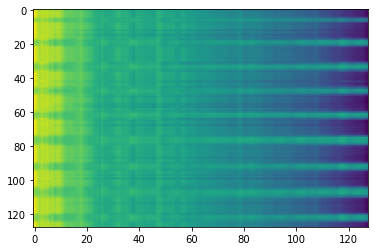

2020-11-07 21:37:18,239 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:17.453362, valid_AUC:0.568327, valid_pAUC:0.498647
100%|██████████| 1246/1246 [00:10<00:00, 121.06it/s]
2020-11-07 21:37:41,663 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:17.251803, valid_AUC:0.595845, valid_pAUC:0.510109
100%|██████████| 1246/1246 [00:10<00:00, 121.46it/s]
2020-11-07 21:38:04,963 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:16.845752, valid_AUC:0.619368, valid_pAUC:0.510592
100%|██████████| 1246/1246 [00:10<00:00, 121.05it/s]
2020-11-07 21:38:28,322 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:16.233025, valid_AUC:0.622367, valid_pAUC:0.520437
100%|██████████| 1246/1246 [00:10<00:00, 122.10it/s]
2020-11-07 21:38:51,674 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:15.812561, valid_AUC:0.625564, valid_pAUC:0.510623
100%|██████████| 1246/1246 [00:10<00:00, 121.55it/s]
2020-11-07 21:39:14,994 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:15.406253, v

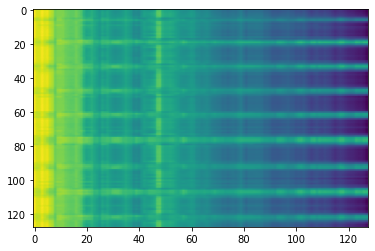

2020-11-07 21:41:17,636 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:14.139776, valid_AUC:0.635115, valid_pAUC:0.513889
100%|██████████| 1246/1246 [00:10<00:00, 119.59it/s]
2020-11-07 21:41:41,656 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:14.002362, valid_AUC:0.625476, valid_pAUC:0.510265
100%|██████████| 1246/1246 [00:11<00:00, 112.80it/s]
2020-11-07 21:42:06,226 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:13.727363, valid_AUC:0.660331, valid_pAUC:0.520934
100%|██████████| 1246/1246 [00:11<00:00, 111.04it/s]
2020-11-07 21:42:31,263 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:13.619843, valid_AUC:0.668694, valid_pAUC:0.521899
100%|██████████| 1246/1246 [00:10<00:00, 119.71it/s]
2020-11-07 21:42:55,100 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:13.341547, valid_AUC:0.664970, valid_pAUC:0.520141
100%|██████████| 1246/1246 [00:11<00:00, 112.54it/s]
2020-11-07 21:43:19,415 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:13.210626, v

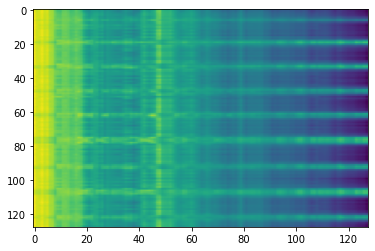

2020-11-07 21:45:23,936 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:12.753249, valid_AUC:0.695783, valid_pAUC:0.525616
100%|██████████| 1246/1246 [00:11<00:00, 110.11it/s]
2020-11-07 21:45:48,628 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:12.648508, valid_AUC:0.677435, valid_pAUC:0.523190
100%|██████████| 1246/1246 [00:11<00:00, 109.44it/s]
2020-11-07 21:46:13,647 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:12.536843, valid_AUC:0.696176, valid_pAUC:0.526642
100%|██████████| 1246/1246 [00:11<00:00, 109.08it/s]
2020-11-07 21:46:38,891 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:12.534315, valid_AUC:0.684229, valid_pAUC:0.529706
100%|██████████| 1246/1246 [00:10<00:00, 116.26it/s]
2020-11-07 21:47:02,943 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:12.540892, valid_AUC:0.693534, valid_pAUC:0.527093
100%|██████████| 1246/1246 [00:10<00:00, 116.98it/s]
2020-11-07 21:47:27,032 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:12.563431, v

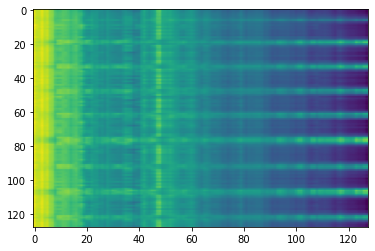

2020-11-07 21:49:30,691 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:12.279002, valid_AUC:0.719025, valid_pAUC:0.538401
100%|██████████| 1246/1246 [00:11<00:00, 110.36it/s]
2020-11-07 21:49:55,534 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:12.287983, valid_AUC:0.714722, valid_pAUC:0.542071
100%|██████████| 1246/1246 [00:10<00:00, 118.68it/s]
2020-11-07 21:50:19,373 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:12.208473, valid_AUC:0.714835, valid_pAUC:0.542989
100%|██████████| 1246/1246 [00:10<00:00, 118.33it/s]
2020-11-07 21:50:43,536 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:12.309830, valid_AUC:0.727465, valid_pAUC:0.552321
100%|██████████| 1246/1246 [00:10<00:00, 114.56it/s]
2020-11-07 21:51:08,018 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:12.174577, valid_AUC:0.719368, valid_pAUC:0.546441
100%|██████████| 1246/1246 [00:10<00:00, 114.82it/s]
2020-11-07 21:51:32,367 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:12.232917, v

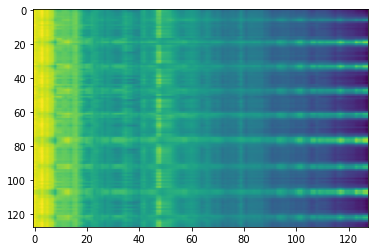

2020-11-07 21:53:34,089 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:11.949402, valid_AUC:0.724702, valid_pAUC:0.554125
100%|██████████| 1246/1246 [00:10<00:00, 114.20it/s]
2020-11-07 21:53:58,314 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:11.943288, valid_AUC:0.737982, valid_pAUC:0.564841
100%|██████████| 1246/1246 [00:10<00:00, 118.63it/s]
2020-11-07 21:54:22,409 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:11.884651, valid_AUC:0.740378, valid_pAUC:0.574188
100%|██████████| 1246/1246 [00:10<00:00, 117.71it/s]
2020-11-07 21:54:46,331 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:11.863192, valid_AUC:0.739155, valid_pAUC:0.567998
100%|██████████| 1246/1246 [00:10<00:00, 121.42it/s]
2020-11-07 21:55:09,789 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:11.940146, valid_AUC:0.738233, valid_pAUC:0.564110
100%|██████████| 1246/1246 [00:10<00:00, 121.81it/s]
2020-11-07 21:55:33,087 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:11.850971, v

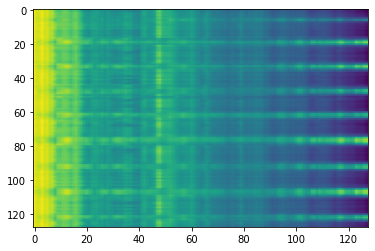

2020-11-07 21:57:30,440 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:11.831497, valid_AUC:0.723126, valid_pAUC:0.551978
100%|██████████| 1246/1246 [00:10<00:00, 121.34it/s]
2020-11-07 21:57:53,852 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:11.802429, valid_AUC:0.739332, valid_pAUC:0.572260
100%|██████████| 1246/1246 [00:10<00:00, 120.75it/s]
2020-11-07 21:58:17,375 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:11.741258, valid_AUC:0.736466, valid_pAUC:0.573644
100%|██████████| 1246/1246 [00:10<00:00, 119.13it/s]
2020-11-07 21:58:40,869 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:11.758870, valid_AUC:0.756616, valid_pAUC:0.581545
100%|██████████| 1246/1246 [00:10<00:00, 120.11it/s]
2020-11-07 21:59:04,390 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:11.794566, valid_AUC:0.736082, valid_pAUC:0.565416
100%|██████████| 1246/1246 [00:10<00:00, 120.85it/s]
2020-11-07 21:59:27,893 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:11.794899, v

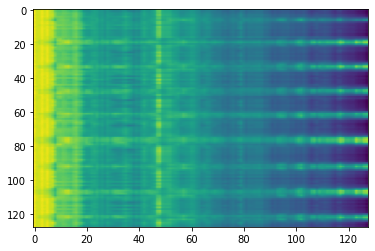

2020-11-07 22:01:25,099 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:11.646684, valid_AUC:0.751528, valid_pAUC:0.575028
100%|██████████| 1246/1246 [00:10<00:00, 121.94it/s]
2020-11-07 22:01:48,362 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:11.683779, valid_AUC:0.745337, valid_pAUC:0.573504
100%|██████████| 1246/1246 [00:10<00:00, 121.04it/s]
2020-11-07 22:02:11,742 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:11.629882, valid_AUC:0.754450, valid_pAUC:0.582696
100%|██████████| 1246/1246 [00:11<00:00, 113.13it/s]
2020-11-07 22:02:36,311 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:11.586833, valid_AUC:0.738806, valid_pAUC:0.562772
100%|██████████| 1246/1246 [00:10<00:00, 121.04it/s]
2020-11-07 22:02:59,682 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:11.708422, valid_AUC:0.756596, valid_pAUC:0.579881
100%|██████████| 1246/1246 [00:10<00:00, 121.27it/s]
2020-11-07 22:03:23,208 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:11.618452, v

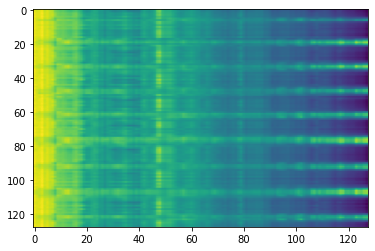

2020-11-07 22:05:20,833 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:11.551264, valid_AUC:0.745869, valid_pAUC:0.563705
100%|██████████| 1246/1246 [00:10<00:00, 122.25it/s]
2020-11-07 22:05:44,007 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:11.424091, valid_AUC:0.754731, valid_pAUC:0.572571
100%|██████████| 1246/1246 [00:10<00:00, 121.83it/s]
2020-11-07 22:06:07,312 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:11.295367, valid_AUC:0.752849, valid_pAUC:0.569538
100%|██████████| 1246/1246 [00:10<00:00, 122.78it/s]
2020-11-07 22:06:30,532 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:11.260510, valid_AUC:0.761253, valid_pAUC:0.570160
100%|██████████| 1246/1246 [00:10<00:00, 121.00it/s]
2020-11-07 22:06:54,345 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:11.222383, valid_AUC:0.748833, valid_pAUC:0.566987
100%|██████████| 1246/1246 [00:10<00:00, 122.23it/s]
2020-11-07 22:07:17,756 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:11.183004, v

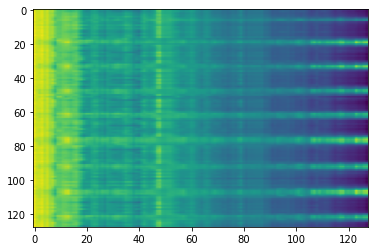

2020-11-07 22:09:15,239 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:11.096826, valid_AUC:0.753381, valid_pAUC:0.571684
100%|██████████| 1246/1246 [00:10<00:00, 121.31it/s]
2020-11-07 22:09:38,697 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:11.039464, valid_AUC:0.752550, valid_pAUC:0.580192
100%|██████████| 1246/1246 [00:10<00:00, 120.05it/s]
2020-11-07 22:10:02,587 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:11.020769, valid_AUC:0.755523, valid_pAUC:0.576241
100%|██████████| 1246/1246 [00:10<00:00, 121.12it/s]
2020-11-07 22:10:26,008 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:10.994434, valid_AUC:0.764631, valid_pAUC:0.583427
100%|██████████| 1246/1246 [00:10<00:00, 121.21it/s]
2020-11-07 22:10:49,529 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:11.022065, valid_AUC:0.729285, valid_pAUC:0.557189
100%|██████████| 1246/1246 [00:10<00:00, 120.00it/s]
2020-11-07 22:11:13,061 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:11.000738, v

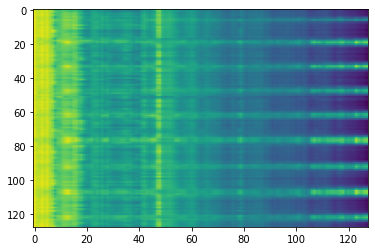

2020-11-07 22:13:11,655 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:10.836913, valid_AUC:0.768165, valid_pAUC:0.580145
2020-11-07 22:13:11,700 - 00_train.py - INFO - 
 success:slider 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AEs/bidirectional_LSTM_AE/models/slider_model.pth


elapsed time: 2462.407910585 [sec]


2020-11-07 22:13:12,203 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2020-11-07 22:13:12,204 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-07 22:13:12,205 - 00_train.py - INFO - TRAINING
  0%|          | 0/219 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 2407/2407 [00:34<00:00, 69.49it/s]


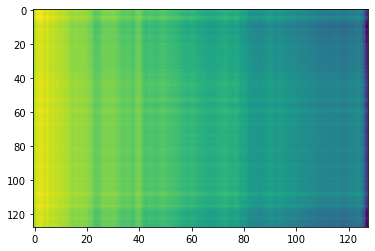

2020-11-07 22:15:17,329 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:63.390846, valid_AUC:0.630666, valid_pAUC:0.531471
100%|██████████| 2407/2407 [00:20<00:00, 117.25it/s]
2020-11-07 22:15:56,104 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:15.682094, valid_AUC:0.631777, valid_pAUC:0.529743
100%|██████████| 2407/2407 [00:20<00:00, 119.65it/s]
2020-11-07 22:16:34,287 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:15.542515, valid_AUC:0.647140, valid_pAUC:0.526704
100%|██████████| 2407/2407 [00:20<00:00, 119.54it/s]
2020-11-07 22:17:12,352 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:15.353039, valid_AUC:0.640896, valid_pAUC:0.524348
100%|██████████| 2407/2407 [00:20<00:00, 115.19it/s]
2020-11-07 22:17:51,367 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:15.404140, valid_AUC:0.640595, valid_pAUC:0.527880
100%|██████████| 2407/2407 [00:20<00:00, 116.94it/s]
2020-11-07 22:18:30,151 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:15.438179, valid_A

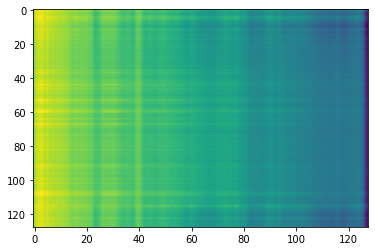

2020-11-07 22:21:03,587 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:15.274239, valid_AUC:0.637280, valid_pAUC:0.522624
100%|██████████| 2407/2407 [00:20<00:00, 119.95it/s]
2020-11-07 22:21:41,799 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:15.110081, valid_AUC:0.675576, valid_pAUC:0.531527
100%|██████████| 2407/2407 [00:20<00:00, 117.59it/s]
2020-11-07 22:22:20,381 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:14.973344, valid_AUC:0.659998, valid_pAUC:0.533995
100%|██████████| 2407/2407 [00:20<00:00, 118.59it/s]
2020-11-07 22:22:58,954 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:14.051293, valid_AUC:0.686546, valid_pAUC:0.579884
100%|██████████| 2407/2407 [00:20<00:00, 117.01it/s]
2020-11-07 22:23:38,074 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:13.241479, valid_AUC:0.737944, valid_pAUC:0.591122
100%|██████████| 2407/2407 [00:20<00:00, 117.60it/s]
2020-11-07 22:24:16,907 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:12.910332, v

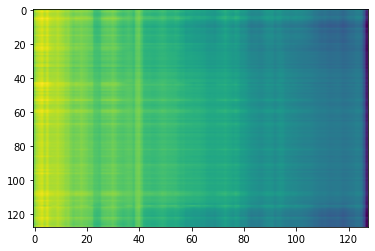

2020-11-07 22:27:40,619 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:12.629890, valid_AUC:0.752798, valid_pAUC:0.586955
100%|██████████| 2407/2407 [00:20<00:00, 116.12it/s]
2020-11-07 22:28:19,941 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:12.538267, valid_AUC:0.726060, valid_pAUC:0.573374
100%|██████████| 2407/2407 [00:22<00:00, 108.97it/s]
2020-11-07 22:29:01,026 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:12.444494, valid_AUC:0.723185, valid_pAUC:0.561797
100%|██████████| 2407/2407 [00:22<00:00, 107.02it/s]
2020-11-07 22:29:42,523 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:12.365212, valid_AUC:0.773228, valid_pAUC:0.599988
100%|██████████| 2407/2407 [00:20<00:00, 114.64it/s]
2020-11-07 22:30:22,196 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:12.395805, valid_AUC:0.761279, valid_pAUC:0.585608
100%|██████████| 2407/2407 [00:20<00:00, 119.81it/s]
2020-11-07 22:31:00,694 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:12.419270, v

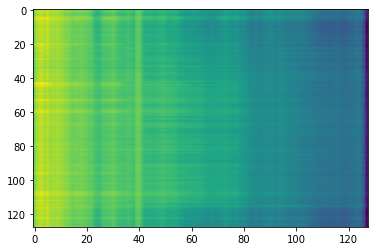

2020-11-07 22:34:16,892 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:12.309879, valid_AUC:0.711175, valid_pAUC:0.570820
100%|██████████| 2407/2407 [00:19<00:00, 120.56it/s]
2020-11-07 22:34:55,234 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:12.223441, valid_AUC:0.729991, valid_pAUC:0.574217
100%|██████████| 2407/2407 [00:20<00:00, 117.91it/s]
2020-11-07 22:35:33,729 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:12.240775, valid_AUC:0.718716, valid_pAUC:0.578410
100%|██████████| 2407/2407 [00:20<00:00, 117.94it/s]
2020-11-07 22:36:12,241 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:12.120181, valid_AUC:0.719046, valid_pAUC:0.566852
100%|██████████| 2407/2407 [00:20<00:00, 116.00it/s]
2020-11-07 22:36:50,973 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:11.912261, valid_AUC:0.692875, valid_pAUC:0.566150
100%|██████████| 2407/2407 [00:20<00:00, 116.91it/s]
2020-11-07 22:37:29,628 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:11.687393, v

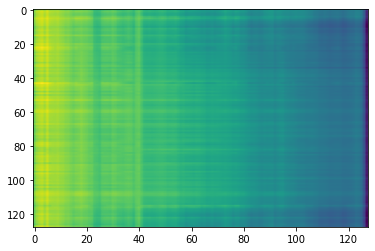

2020-11-07 22:40:43,299 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:11.323617, valid_AUC:0.769921, valid_pAUC:0.603684
100%|██████████| 2407/2407 [00:20<00:00, 119.73it/s]
2020-11-07 22:41:21,445 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:11.253834, valid_AUC:0.741810, valid_pAUC:0.595419
100%|██████████| 2407/2407 [00:20<00:00, 117.34it/s]
2020-11-07 22:42:00,302 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:11.226443, valid_AUC:0.724184, valid_pAUC:0.581206
100%|██████████| 2407/2407 [00:20<00:00, 115.96it/s]
2020-11-07 22:42:39,318 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:11.224793, valid_AUC:0.704729, valid_pAUC:0.582789
100%|██████████| 2407/2407 [00:20<00:00, 118.75it/s]
2020-11-07 22:43:17,540 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:11.211356, valid_AUC:0.742072, valid_pAUC:0.596303
100%|██████████| 2407/2407 [00:20<00:00, 120.01it/s]
2020-11-07 22:43:55,730 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:11.125961, v

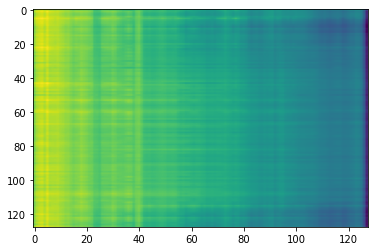

2020-11-07 22:47:09,361 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:10.907542, valid_AUC:0.754945, valid_pAUC:0.605312
100%|██████████| 2407/2407 [00:20<00:00, 115.42it/s]
2020-11-07 22:47:48,350 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:10.861718, valid_AUC:0.728328, valid_pAUC:0.593612
100%|██████████| 2407/2407 [00:20<00:00, 117.18it/s]
2020-11-07 22:48:26,922 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:10.878787, valid_AUC:0.728555, valid_pAUC:0.597061
100%|██████████| 2407/2407 [00:20<00:00, 116.31it/s]
2020-11-07 22:49:05,748 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:10.852049, valid_AUC:0.715565, valid_pAUC:0.587261
100%|██████████| 2407/2407 [00:20<00:00, 114.67it/s]
2020-11-07 22:49:45,265 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:10.767318, valid_AUC:0.734006, valid_pAUC:0.588822
100%|██████████| 2407/2407 [00:20<00:00, 115.97it/s]
2020-11-07 22:50:24,025 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:10.768729, v

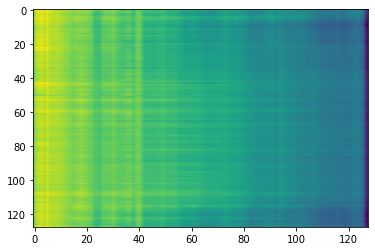

2020-11-07 22:53:39,873 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:10.663407, valid_AUC:0.766033, valid_pAUC:0.599264
100%|██████████| 2407/2407 [00:21<00:00, 114.39it/s]
2020-11-07 22:54:19,167 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:10.652614, valid_AUC:0.740999, valid_pAUC:0.591234
100%|██████████| 2407/2407 [00:20<00:00, 117.87it/s]
2020-11-07 22:54:58,024 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:10.649328, valid_AUC:0.749136, valid_pAUC:0.600052
100%|██████████| 2407/2407 [00:20<00:00, 117.60it/s]
2020-11-07 22:55:36,517 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:10.650890, valid_AUC:0.746463, valid_pAUC:0.588680
100%|██████████| 2407/2407 [00:20<00:00, 118.07it/s]
2020-11-07 22:56:14,713 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:10.622468, valid_AUC:0.726287, valid_pAUC:0.585249
100%|██████████| 2407/2407 [00:21<00:00, 113.36it/s]
2020-11-07 22:56:54,338 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:10.627071, v

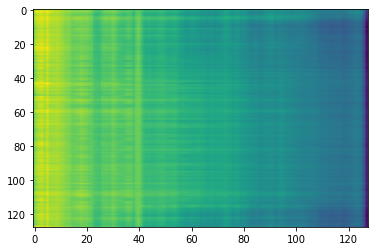

2020-11-07 23:00:14,864 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:10.481770, valid_AUC:0.746782, valid_pAUC:0.592096
100%|██████████| 2407/2407 [00:21<00:00, 113.15it/s]
2020-11-07 23:00:54,610 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:10.453210, valid_AUC:0.737182, valid_pAUC:0.595295
100%|██████████| 2407/2407 [00:21<00:00, 111.64it/s]
2020-11-07 23:01:35,331 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:10.513998, valid_AUC:0.735517, valid_pAUC:0.588990
100%|██████████| 2407/2407 [00:21<00:00, 112.71it/s]
2020-11-07 23:02:15,734 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:10.446435, valid_AUC:0.728077, valid_pAUC:0.596781
100%|██████████| 2407/2407 [00:20<00:00, 115.59it/s]
2020-11-07 23:02:55,429 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:10.385185, valid_AUC:0.731207, valid_pAUC:0.596305
100%|██████████| 2407/2407 [00:20<00:00, 118.35it/s]
2020-11-07 23:03:34,134 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:10.383689, v

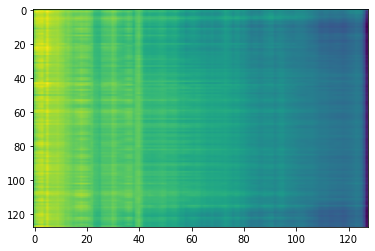

2020-11-07 23:06:48,740 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:10.269205, valid_AUC:0.736555, valid_pAUC:0.595239
100%|██████████| 2407/2407 [00:20<00:00, 114.73it/s]
2020-11-07 23:07:27,902 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:10.277072, valid_AUC:0.720663, valid_pAUC:0.593869
100%|██████████| 2407/2407 [00:21<00:00, 111.87it/s]
2020-11-07 23:08:07,414 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:10.229754, valid_AUC:0.726053, valid_pAUC:0.596841
100%|██████████| 2407/2407 [00:20<00:00, 114.99it/s]
2020-11-07 23:08:46,334 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:10.198367, valid_AUC:0.738436, valid_pAUC:0.597763
100%|██████████| 2407/2407 [00:21<00:00, 113.50it/s]
2020-11-07 23:09:25,509 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:10.186864, valid_AUC:0.738827, valid_pAUC:0.595400
100%|██████████| 2407/2407 [00:21<00:00, 114.57it/s]
2020-11-07 23:10:04,975 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:10.163028, v

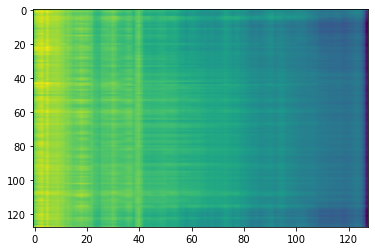

2020-11-07 23:13:22,183 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:10.111559, valid_AUC:0.735269, valid_pAUC:0.600193
100%|██████████| 2407/2407 [00:21<00:00, 113.92it/s]
2020-11-07 23:14:01,650 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:10.130842, valid_AUC:0.749870, valid_pAUC:0.605965
100%|██████████| 2407/2407 [00:21<00:00, 112.62it/s]
2020-11-07 23:14:41,590 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:10.120678, valid_AUC:0.746813, valid_pAUC:0.601728
100%|██████████| 2407/2407 [00:20<00:00, 115.05it/s]
2020-11-07 23:15:20,691 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:10.055349, valid_AUC:0.761396, valid_pAUC:0.606327
100%|██████████| 2407/2407 [00:21<00:00, 114.37it/s]
2020-11-07 23:16:00,151 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:10.017790, valid_AUC:0.746352, valid_pAUC:0.597875
100%|██████████| 2407/2407 [00:20<00:00, 117.71it/s]
2020-11-07 23:16:39,042 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:10.030975, v

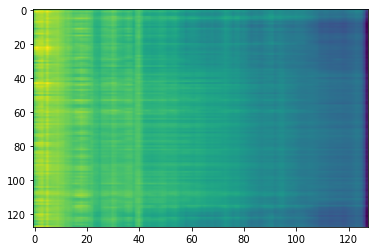

2020-11-07 23:19:52,960 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:9.875391, valid_AUC:0.741710, valid_pAUC:0.594579
2020-11-07 23:19:53,006 - 00_train.py - INFO - 
 success:ToyCar 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AEs/bidirectional_LSTM_AE/models/ToyCar_model.pth


elapsed time: 4000.804147720 [sec]


2020-11-07 23:19:53,694 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyConveyor
2020-11-07 23:19:53,695 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-07 23:19:53,696 - 00_train.py - INFO - TRAINING
  0%|          | 0/188 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 3452/3452 [00:48<00:00, 71.77it/s]


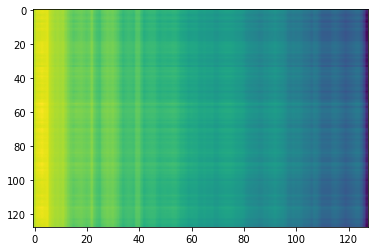

2020-11-07 23:21:58,046 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:48.149787, valid_AUC:0.541911, valid_pAUC:0.505871
100%|██████████| 3452/3452 [00:29<00:00, 115.32it/s]
2020-11-07 23:22:43,399 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:17.071487, valid_AUC:0.541428, valid_pAUC:0.506161
100%|██████████| 3452/3452 [00:30<00:00, 113.14it/s]
2020-11-07 23:23:29,424 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:17.035119, valid_AUC:0.525930, valid_pAUC:0.506134
100%|██████████| 3452/3452 [00:30<00:00, 112.29it/s]
2020-11-07 23:24:15,747 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:16.961916, valid_AUC:0.514156, valid_pAUC:0.508196
100%|██████████| 3452/3452 [00:30<00:00, 113.76it/s]
2020-11-07 23:25:01,711 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:17.219992, valid_AUC:0.524147, valid_pAUC:0.508364
100%|██████████| 3452/3452 [00:30<00:00, 115.02it/s]
2020-11-07 23:25:47,166 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:17.002279, valid_A

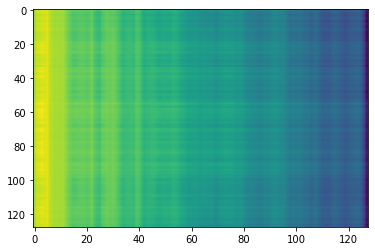

2020-11-07 23:28:51,957 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:16.884348, valid_AUC:0.544691, valid_pAUC:0.506764
100%|██████████| 3452/3452 [00:30<00:00, 112.45it/s]
2020-11-07 23:29:38,402 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:17.057714, valid_AUC:0.546631, valid_pAUC:0.505820
100%|██████████| 3452/3452 [00:29<00:00, 115.66it/s]
2020-11-07 23:30:24,029 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:16.830845, valid_AUC:0.554504, valid_pAUC:0.506371
100%|██████████| 3452/3452 [00:30<00:00, 114.82it/s]
2020-11-07 23:31:09,904 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:17.031231, valid_AUC:0.547374, valid_pAUC:0.506282
100%|██████████| 3452/3452 [00:30<00:00, 113.58it/s]
2020-11-07 23:31:56,386 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:16.744759, valid_AUC:0.543299, valid_pAUC:0.506417
100%|██████████| 3452/3452 [00:30<00:00, 113.94it/s]
2020-11-07 23:32:42,513 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:16.780861, v

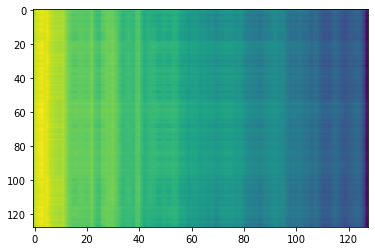

2020-11-07 23:36:31,218 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:16.984345, valid_AUC:0.552865, valid_pAUC:0.508098
100%|██████████| 3452/3452 [00:29<00:00, 115.77it/s]
2020-11-07 23:37:16,646 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:16.754378, valid_AUC:0.550866, valid_pAUC:0.508138
100%|██████████| 3452/3452 [00:29<00:00, 116.28it/s]
2020-11-07 23:38:02,017 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:16.833983, valid_AUC:0.546121, valid_pAUC:0.512836
100%|██████████| 3452/3452 [00:30<00:00, 111.47it/s]
2020-11-07 23:38:49,193 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:16.329532, valid_AUC:0.562012, valid_pAUC:0.507510
100%|██████████| 3452/3452 [00:30<00:00, 114.66it/s]
2020-11-07 23:39:34,904 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:15.857511, valid_AUC:0.557673, valid_pAUC:0.507062
100%|██████████| 3452/3452 [00:29<00:00, 117.05it/s]
2020-11-07 23:40:19,903 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:15.438145, v

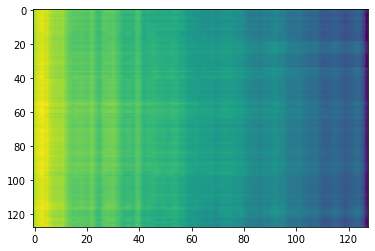

2020-11-07 23:44:13,177 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:14.438696, valid_AUC:0.580401, valid_pAUC:0.507660
100%|██████████| 3452/3452 [00:30<00:00, 114.34it/s]
2020-11-07 23:44:59,338 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:14.279380, valid_AUC:0.569650, valid_pAUC:0.511150
100%|██████████| 3452/3452 [00:30<00:00, 111.50it/s]
2020-11-07 23:45:45,788 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:14.255630, valid_AUC:0.585870, valid_pAUC:0.512785
100%|██████████| 3452/3452 [00:30<00:00, 113.68it/s]
2020-11-07 23:46:32,082 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:14.486296, valid_AUC:0.584445, valid_pAUC:0.512872
100%|██████████| 3452/3452 [00:31<00:00, 111.00it/s]
2020-11-07 23:47:19,219 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:14.176975, valid_AUC:0.580261, valid_pAUC:0.513777
100%|██████████| 3452/3452 [00:30<00:00, 114.22it/s]
2020-11-07 23:48:04,779 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:13.916260, v

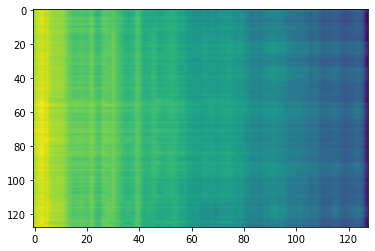

2020-11-07 23:51:52,531 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:13.463606, valid_AUC:0.616290, valid_pAUC:0.516308
100%|██████████| 3452/3452 [00:30<00:00, 115.05it/s]
2020-11-07 23:52:38,436 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:13.389687, valid_AUC:0.613245, valid_pAUC:0.518744
100%|██████████| 3452/3452 [00:29<00:00, 116.43it/s]
2020-11-07 23:53:23,632 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:13.316816, valid_AUC:0.623821, valid_pAUC:0.516829
100%|██████████| 3452/3452 [00:30<00:00, 114.79it/s]
2020-11-07 23:54:09,134 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:13.221455, valid_AUC:0.619581, valid_pAUC:0.514981
100%|██████████| 3452/3452 [00:30<00:00, 113.10it/s]
2020-11-07 23:54:55,311 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:13.158477, valid_AUC:0.612840, valid_pAUC:0.517048
100%|██████████| 3452/3452 [00:29<00:00, 116.82it/s]
2020-11-07 23:55:40,362 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:13.119109, v

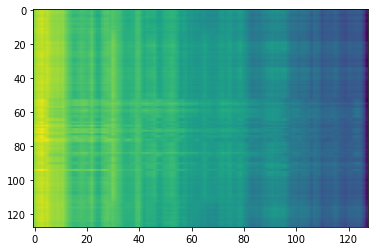

2020-11-07 23:59:27,336 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:12.761681, valid_AUC:0.634433, valid_pAUC:0.519008
100%|██████████| 3452/3452 [00:29<00:00, 117.62it/s]
2020-11-08 00:00:12,312 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:12.835221, valid_AUC:0.643168, valid_pAUC:0.520395
100%|██████████| 3452/3452 [00:29<00:00, 117.13it/s]
2020-11-08 00:00:57,382 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:12.699671, valid_AUC:0.643869, valid_pAUC:0.518466
100%|██████████| 3452/3452 [00:30<00:00, 113.93it/s]
2020-11-08 00:01:43,131 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:12.786036, valid_AUC:0.620868, valid_pAUC:0.517628
100%|██████████| 3452/3452 [00:30<00:00, 113.90it/s]
2020-11-08 00:02:29,391 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:12.654898, valid_AUC:0.658690, valid_pAUC:0.527459
100%|██████████| 3452/3452 [00:29<00:00, 118.85it/s]
2020-11-08 00:03:13,978 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:12.687457, v

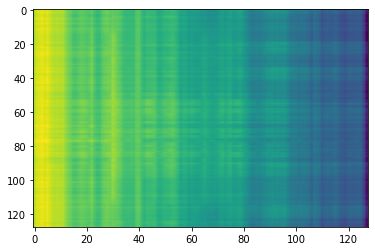

2020-11-08 00:07:00,474 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:12.436760, valid_AUC:0.629230, valid_pAUC:0.540241
100%|██████████| 3452/3452 [00:29<00:00, 115.10it/s]
2020-11-08 00:07:46,281 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:12.308319, valid_AUC:0.629263, valid_pAUC:0.535869
100%|██████████| 3452/3452 [00:28<00:00, 119.51it/s]
2020-11-08 00:08:30,763 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:12.180308, valid_AUC:0.623144, valid_pAUC:0.526679
100%|██████████| 3452/3452 [00:28<00:00, 119.86it/s]
2020-11-08 00:09:15,043 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:12.145524, valid_AUC:0.636173, valid_pAUC:0.542444
100%|██████████| 3452/3452 [00:28<00:00, 120.09it/s]
2020-11-08 00:09:59,092 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:12.185327, valid_AUC:0.647870, valid_pAUC:0.539709
100%|██████████| 3452/3452 [00:30<00:00, 114.27it/s]
2020-11-08 00:10:45,081 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:12.051263, v

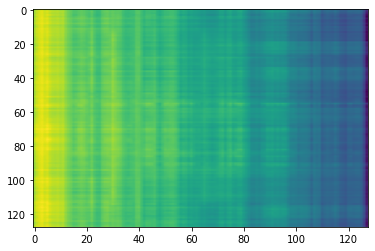

2020-11-08 00:14:33,768 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:11.747711, valid_AUC:0.641048, valid_pAUC:0.550917
100%|██████████| 3452/3452 [00:29<00:00, 117.02it/s]
2020-11-08 00:15:18,850 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:11.693819, valid_AUC:0.655214, valid_pAUC:0.545128
100%|██████████| 3452/3452 [00:30<00:00, 114.12it/s]
2020-11-08 00:16:04,899 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:11.722118, valid_AUC:0.658796, valid_pAUC:0.548483
100%|██████████| 3452/3452 [00:31<00:00, 111.15it/s]
2020-11-08 00:16:52,408 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:11.609738, valid_AUC:0.670249, valid_pAUC:0.549360
100%|██████████| 3452/3452 [00:31<00:00, 111.18it/s]
2020-11-08 00:17:38,801 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:11.590477, valid_AUC:0.650732, valid_pAUC:0.546450
100%|██████████| 3452/3452 [00:31<00:00, 111.10it/s]
2020-11-08 00:18:26,127 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:11.516921, v

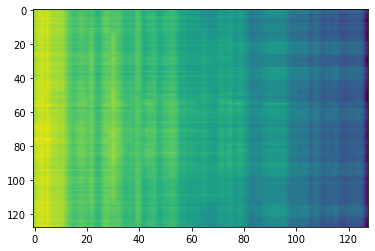

2020-11-08 00:22:17,781 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:11.442698, valid_AUC:0.664056, valid_pAUC:0.556979
100%|██████████| 3452/3452 [00:30<00:00, 113.58it/s]
2020-11-08 00:23:04,312 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:11.388086, valid_AUC:0.665200, valid_pAUC:0.561275
100%|██████████| 3452/3452 [00:30<00:00, 112.93it/s]
2020-11-08 00:23:51,211 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:11.520056, valid_AUC:0.665531, valid_pAUC:0.558782
100%|██████████| 3452/3452 [00:29<00:00, 115.48it/s]
2020-11-08 00:24:36,546 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:11.391716, valid_AUC:0.674484, valid_pAUC:0.559465
100%|██████████| 3452/3452 [00:29<00:00, 116.99it/s]
2020-11-08 00:25:21,422 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:11.381767, valid_AUC:0.660312, valid_pAUC:0.530894
100%|██████████| 3452/3452 [00:29<00:00, 115.46it/s]
2020-11-08 00:26:06,892 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:11.400080, v

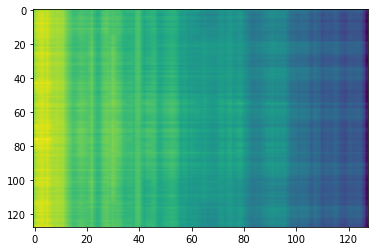

2020-11-08 00:29:52,556 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:11.316420, valid_AUC:0.665208, valid_pAUC:0.557142
100%|██████████| 3452/3452 [00:29<00:00, 117.39it/s]
2020-11-08 00:30:37,474 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:11.190073, valid_AUC:0.686550, valid_pAUC:0.566359
100%|██████████| 3452/3452 [00:31<00:00, 110.47it/s]
2020-11-08 00:31:25,127 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:11.145724, valid_AUC:0.683506, valid_pAUC:0.556345
100%|██████████| 3452/3452 [00:30<00:00, 113.37it/s]
2020-11-08 00:32:11,173 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:11.196732, valid_AUC:0.663306, valid_pAUC:0.563943
100%|██████████| 3452/3452 [00:33<00:00, 104.07it/s]
2020-11-08 00:33:00,858 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:11.255256, valid_AUC:0.686945, valid_pAUC:0.565445
100%|██████████| 3452/3452 [00:29<00:00, 115.81it/s]
2020-11-08 00:33:46,371 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:11.079862, v

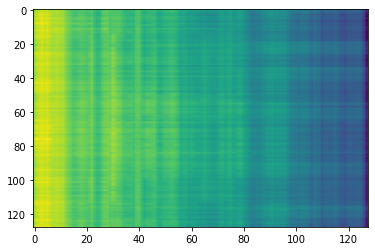

2020-11-08 00:37:39,835 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:11.044775, valid_AUC:0.696730, valid_pAUC:0.572949
2020-11-08 00:37:39,889 - 00_train.py - INFO - 
 success:ToyConveyor 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AEs/bidirectional_LSTM_AE/models/ToyConveyor_model.pth


elapsed time: 4666.195763350 [sec]


2020-11-08 00:37:40,520 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2020-11-08 00:37:40,522 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-08 00:37:40,524 - 00_train.py - INFO - TRAINING
  0%|          | 0/182 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 855/855 [00:13<00:00, 64.73it/s]


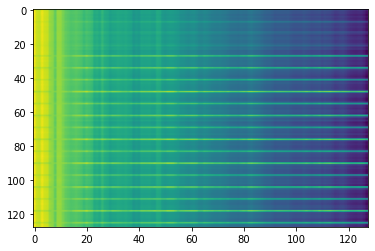

2020-11-08 00:39:07,892 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:82.349021, valid_AUC:0.492071, valid_pAUC:0.492366
100%|██████████| 855/855 [00:07<00:00, 110.27it/s]
2020-11-08 00:39:31,370 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:19.710277, valid_AUC:0.489648, valid_pAUC:0.489792
100%|██████████| 855/855 [00:07<00:00, 112.38it/s]
2020-11-08 00:39:54,489 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:19.664996, valid_AUC:0.491566, valid_pAUC:0.491151
100%|██████████| 855/855 [00:07<00:00, 112.21it/s]
2020-11-08 00:40:18,131 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:19.528039, valid_AUC:0.490775, valid_pAUC:0.489560
100%|██████████| 855/855 [00:07<00:00, 116.87it/s]
2020-11-08 00:40:40,658 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:19.460791, valid_AUC:0.492264, valid_pAUC:0.489907
100%|██████████| 855/855 [00:07<00:00, 116.09it/s]
2020-11-08 00:41:03,058 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:19.442084, valid_AUC:0.49564

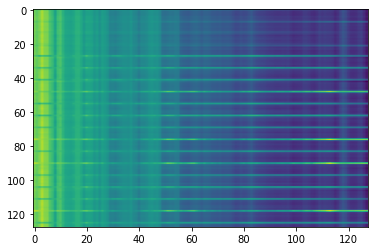

2020-11-08 00:42:33,935 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:16.754679, valid_AUC:0.484110, valid_pAUC:0.490515
100%|██████████| 855/855 [00:08<00:00, 102.05it/s]
2020-11-08 00:42:57,816 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:16.164907, valid_AUC:0.487071, valid_pAUC:0.490862
100%|██████████| 855/855 [00:08<00:00, 106.87it/s]
2020-11-08 00:43:22,075 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:15.786458, valid_AUC:0.481000, valid_pAUC:0.489618
100%|██████████| 855/855 [00:08<00:00, 105.72it/s]
2020-11-08 00:43:46,239 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:15.295872, valid_AUC:0.483522, valid_pAUC:0.494303
100%|██████████| 855/855 [00:07<00:00, 109.68it/s]
2020-11-08 00:44:09,586 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:15.077561, valid_AUC:0.487538, valid_pAUC:0.494187
100%|██████████| 855/855 [00:08<00:00, 102.26it/s]
2020-11-08 00:44:33,102 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:14.701905, valid_AUC:0

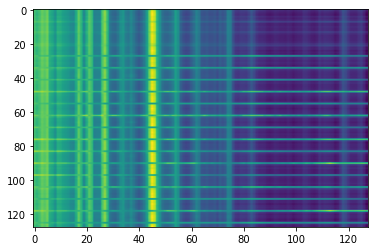

2020-11-08 00:46:29,999 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:12.982873, valid_AUC:0.492731, valid_pAUC:0.500434
100%|██████████| 855/855 [00:08<00:00, 105.63it/s]
2020-11-08 00:46:53,790 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:12.694459, valid_AUC:0.490720, valid_pAUC:0.500839
100%|██████████| 855/855 [00:07<00:00, 112.26it/s]
2020-11-08 00:47:17,989 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:12.599143, valid_AUC:0.493225, valid_pAUC:0.502516
100%|██████████| 855/855 [00:07<00:00, 117.18it/s]
2020-11-08 00:47:40,635 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:12.294457, valid_AUC:0.494434, valid_pAUC:0.500983
100%|██████████| 855/855 [00:07<00:00, 113.00it/s]
2020-11-08 00:48:03,476 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:12.208922, valid_AUC:0.496291, valid_pAUC:0.503210
100%|██████████| 855/855 [00:07<00:00, 115.51it/s]
2020-11-08 00:48:26,444 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:12.059201, valid_AUC:0

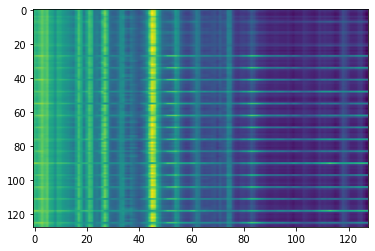

2020-11-08 00:50:20,601 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:11.540278, valid_AUC:0.510599, valid_pAUC:0.500260
100%|██████████| 855/855 [00:07<00:00, 117.04it/s]
2020-11-08 00:50:44,499 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:11.523301, valid_AUC:0.506962, valid_pAUC:0.498930
100%|██████████| 855/855 [00:07<00:00, 115.46it/s]
2020-11-08 00:51:06,872 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:11.480276, valid_AUC:0.509626, valid_pAUC:0.500549
100%|██████████| 855/855 [00:07<00:00, 114.57it/s]
2020-11-08 00:51:29,729 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:11.325680, valid_AUC:0.516291, valid_pAUC:0.500231
100%|██████████| 855/855 [00:07<00:00, 112.41it/s]
2020-11-08 00:51:52,667 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:11.342337, valid_AUC:0.514393, valid_pAUC:0.500607
100%|██████████| 855/855 [00:08<00:00, 104.73it/s]
2020-11-08 00:52:16,347 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:11.362470, valid_AUC:0

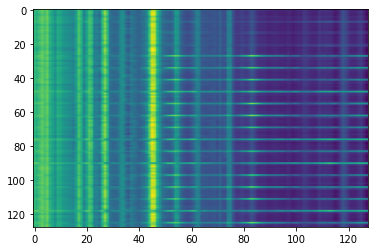

2020-11-08 00:54:14,893 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:11.054647, valid_AUC:0.516319, valid_pAUC:0.498728
100%|██████████| 855/855 [00:08<00:00, 102.24it/s]
2020-11-08 00:54:38,539 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:11.027333, valid_AUC:0.516582, valid_pAUC:0.498178
100%|██████████| 855/855 [00:07<00:00, 114.27it/s]
2020-11-08 00:55:01,454 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:11.018296, valid_AUC:0.516676, valid_pAUC:0.498612
100%|██████████| 855/855 [00:07<00:00, 115.26it/s]
2020-11-08 00:55:24,524 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:10.959750, valid_AUC:0.515588, valid_pAUC:0.499826
100%|██████████| 855/855 [00:07<00:00, 107.02it/s]
2020-11-08 00:55:47,702 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:10.912675, valid_AUC:0.514918, valid_pAUC:0.499277
100%|██████████| 855/855 [00:13<00:00, 63.01it/s]
2020-11-08 00:56:28,280 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:10.898516, valid_AUC:0.

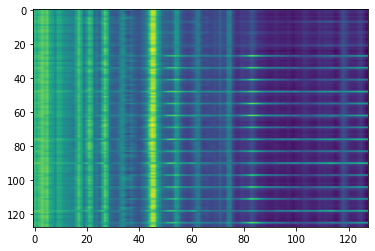

2020-11-08 00:59:41,469 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:10.698452, valid_AUC:0.522423, valid_pAUC:0.499479
100%|██████████| 855/855 [00:09<00:00, 88.95it/s]
2020-11-08 01:00:14,670 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:10.648337, valid_AUC:0.535588, valid_pAUC:0.498728
100%|██████████| 855/855 [00:10<00:00, 84.27it/s]
2020-11-08 01:00:48,401 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:10.614098, valid_AUC:0.532912, valid_pAUC:0.497976
100%|██████████| 855/855 [00:11<00:00, 73.92it/s]
2020-11-08 01:01:23,202 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:10.648848, valid_AUC:0.536313, valid_pAUC:0.499132
100%|██████████| 855/855 [00:12<00:00, 68.15it/s]
2020-11-08 01:01:58,777 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:10.640587, valid_AUC:0.532824, valid_pAUC:0.497773
100%|██████████| 855/855 [00:12<00:00, 69.24it/s]
2020-11-08 01:02:33,983 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:10.530017, valid_AUC:0.5318

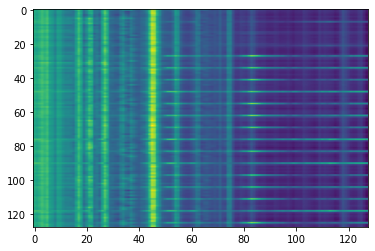

2020-11-08 01:05:23,202 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:10.478762, valid_AUC:0.533099, valid_pAUC:0.497108
100%|██████████| 855/855 [00:11<00:00, 71.27it/s]
2020-11-08 01:05:58,076 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:10.366426, valid_AUC:0.532044, valid_pAUC:0.497744
100%|██████████| 855/855 [00:12<00:00, 69.15it/s]
2020-11-08 01:06:33,524 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:10.367569, valid_AUC:0.540874, valid_pAUC:0.497079
100%|██████████| 855/855 [00:11<00:00, 71.45it/s]
2020-11-08 01:07:08,353 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:10.346908, valid_AUC:0.541126, valid_pAUC:0.497224
100%|██████████| 855/855 [00:12<00:00, 68.77it/s]
2020-11-08 01:07:43,981 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:10.319873, valid_AUC:0.537500, valid_pAUC:0.496935
100%|██████████| 855/855 [00:10<00:00, 80.00it/s]
2020-11-08 01:08:18,952 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:10.213880, valid_AUC:0.5442

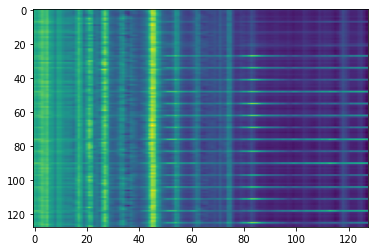

2020-11-08 01:11:13,700 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:10.182247, valid_AUC:0.539187, valid_pAUC:0.498930
100%|██████████| 855/855 [00:12<00:00, 69.71it/s]
2020-11-08 01:11:48,829 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:10.075894, valid_AUC:0.539335, valid_pAUC:0.497021
100%|██████████| 855/855 [00:12<00:00, 68.96it/s]
2020-11-08 01:12:24,226 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:10.007309, valid_AUC:0.542665, valid_pAUC:0.497773
100%|██████████| 855/855 [00:11<00:00, 76.73it/s]
2020-11-08 01:12:58,312 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:9.927755, valid_AUC:0.541632, valid_pAUC:0.498062
100%|██████████| 855/855 [00:10<00:00, 79.55it/s]
2020-11-08 01:13:32,162 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:10.035562, valid_AUC:0.539648, valid_pAUC:0.498265
100%|██████████| 855/855 [00:10<00:00, 84.75it/s]
2020-11-08 01:14:05,397 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:9.901640, valid_AUC:0.540258

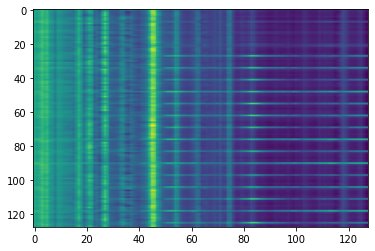

2020-11-08 01:17:24,507 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:9.702798, valid_AUC:0.548022, valid_pAUC:0.498409
100%|██████████| 855/855 [00:15<00:00, 56.09it/s]
2020-11-08 01:18:08,029 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:9.723478, valid_AUC:0.546687, valid_pAUC:0.497137
100%|██████████| 855/855 [00:15<00:00, 54.97it/s]
2020-11-08 01:18:51,986 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:9.697478, valid_AUC:0.541901, valid_pAUC:0.497340
100%|██████████| 855/855 [00:15<00:00, 56.09it/s]
2020-11-08 01:19:36,198 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:9.624215, valid_AUC:0.550736, valid_pAUC:0.498670
100%|██████████| 855/855 [00:14<00:00, 60.43it/s]
2020-11-08 01:20:19,502 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:9.590501, valid_AUC:0.546527, valid_pAUC:0.497571
100%|██████████| 855/855 [00:14<00:00, 60.48it/s]
2020-11-08 01:21:03,249 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:9.618813, valid_AUC:0.546027, va

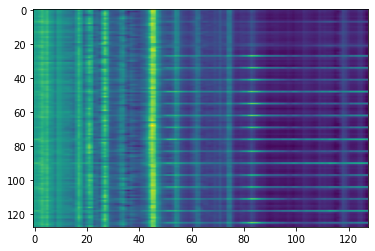

2020-11-08 01:24:39,961 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:9.468036, valid_AUC:0.544275, valid_pAUC:0.498352
100%|██████████| 855/855 [00:13<00:00, 62.01it/s]
2020-11-08 01:25:22,867 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:9.473218, valid_AUC:0.543736, valid_pAUC:0.497947
100%|██████████| 855/855 [00:13<00:00, 64.81it/s]
2020-11-08 01:26:04,700 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:9.400157, valid_AUC:0.546736, valid_pAUC:0.500318
100%|██████████| 855/855 [00:12<00:00, 66.32it/s]
2020-11-08 01:26:46,776 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:9.406329, valid_AUC:0.543434, valid_pAUC:0.498612
100%|██████████| 855/855 [00:12<00:00, 67.50it/s]
2020-11-08 01:27:28,954 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:9.357617, valid_AUC:0.545346, valid_pAUC:0.500260
100%|██████████| 855/855 [00:13<00:00, 62.97it/s]
2020-11-08 01:28:10,849 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:9.300606, valid_AUC:0.551929, va

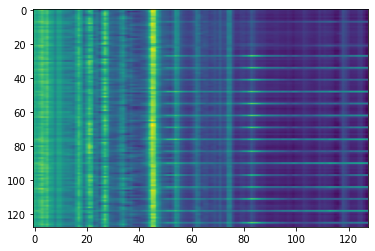

2020-11-08 01:31:42,384 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:9.149812, valid_AUC:0.544066, valid_pAUC:0.500289
2020-11-08 01:31:42,462 - 00_train.py - INFO - 
 success:valve 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/LSTM_AEs/bidirectional_LSTM_AE/models/valve_model.pth


elapsed time: 3241.943235397 [sec]


In [11]:
for machine_type in machine_types:
    history = run(machine_type)
    with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
        pickle.dump(history , file)

history = run('ToyCar')
with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
    pickle.dump(history , file)